In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('cluster_demo').getOrCreate()

In [5]:
# Load data
data = spark.read.csv("../../Data/5000_points.txt", header=False, inferSchema=True, sep='\t')

In [6]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



### Chuẩn hóa dữ liệu

In [7]:
from pyspark.sql.functions import col

In [8]:
data = data.select(col("_c0").alias("x"), col("_c1").alias("y"))

In [9]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



### Chuyễn đổi dữ liệu

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
data.columns

['x', 'y']

In [12]:
vec_assembler = VectorAssembler(inputCols=data.columns, outputCol='features')

In [13]:
final_data = vec_assembler.transform(data)

### Scale dữ liệu

In [14]:
from pyspark.ml.feature import StandardScaler

In [15]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [16]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [17]:
# Normalize each feature to have unit standard deviation
final_data = scalerModel.transform(final_data)

In [18]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



### Xây dựng model

In [19]:
from pyspark.ml.clustering import KMeans

In [20]:
# Train a k-means model
k_list = []
wssse_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    wssse = model.summary.trainingCost
    k_list.append(k)
    wssse_list.append(wssse)
    print('With k=', k, "Set Sum of Squared Errors=", str(wssse))

With k= 2 Set Sum of Squared Errors= 6086.71950821272
With k= 3 Set Sum of Squared Errors= 3706.7469942935554
With k= 4 Set Sum of Squared Errors= 2862.0494367142896
With k= 5 Set Sum of Squared Errors= 2526.099469986608
With k= 6 Set Sum of Squared Errors= 1428.552031646187
With k= 7 Set Sum of Squared Errors= 1239.534477960808
With k= 8 Set Sum of Squared Errors= 912.8886701353701
With k= 9 Set Sum of Squared Errors= 871.9707549756886
With k= 10 Set Sum of Squared Errors= 770.5837429568464


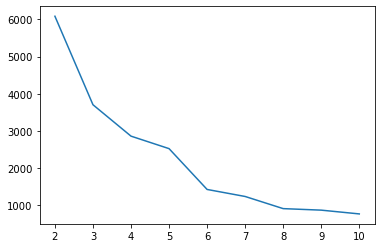

In [21]:
plt.plot(k_list, wssse_list)
plt.show()

Chọn k=8

In [22]:
# Train a k-means model
kmeans = KMeans(featuresCol='scaledFeatures', k=8)
model = kmeans.fit(final_data)

In [23]:
# Evaluate clustering by computing within Set Sum of Squared Errors
wssse = model.summary.trainingCost
print("With Set Sum of Squared Errors=", str(wssse))

With Set Sum of Squared Errors= 912.8886701353701


In [24]:
# Show the result
centers = model.clusterCenters()
print('Cluster Centers:')
for center in centers:
    print(center)

Cluster Centers:
[2.76960693 3.63128545]
[3.38398554 1.00918242]
[3.43256983 2.66251377]
[0.96755054 2.36754019]
[1.70471862 0.71909661]
[0.75463741 1.48020112]
[1.33679274 3.4704405 ]
[2.21696554 1.92807149]


### Dự đoán kết quả

In [25]:
predictions = model.transform(final_data)

In [26]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         7|
|         7|
|         7|
|         7|
|         7|
+----------+
only showing top 5 rows



In [27]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  643|
|         6|  652|
|         3|  678|
|         5|  373|
|         4|  691|
|         7|  918|
|         2|  663|
|         0|  382|
+----------+-----+



In [28]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [29]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [30]:
temp.show(3)

+------------------+------------------+
|                _1|                _2|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
+------------------+------------------+
only showing top 3 rows



In [31]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [32]:
from pyspark.sql.functions import monotonically_increasing_id

In [33]:
temp = temp.withColumn('row_index', monotonically_increasing_id())
data_result = data_result.withColumn('row_index', monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")
temp.show(3)

+------------------+------------------+----------+
|                _1|                _2|prediction|
+------------------+------------------+----------+
| 2.716775610700365| 2.336092297255214|         7|
|2.7236722780340017|2.3658538924649704|         7|
|2.4427660270639544| 2.440366004250274|         7|
+------------------+------------------+----------+
only showing top 3 rows



In [34]:
temp = temp.select(col("_1").alias("x_scale"), col("_2").alias("y_scale"), "prediction")
df = temp.toPandas()

In [35]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1
0,2.769607,3.631285
1,3.383986,1.009182
2,3.432570,2.662514
3,0.967551,2.367540
4,1.704719,0.719097


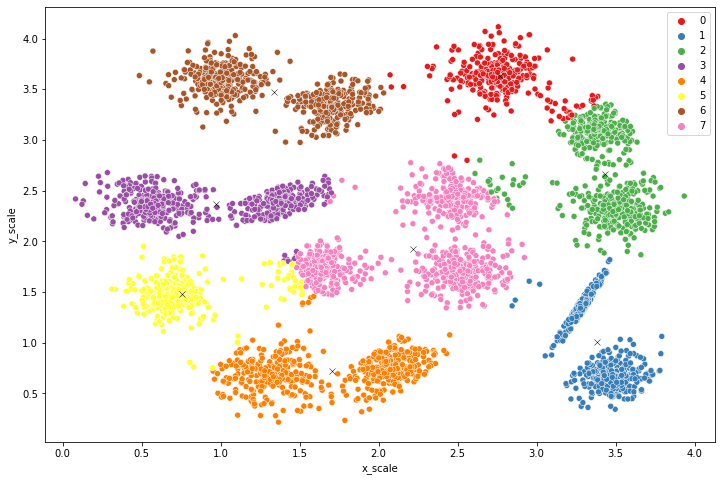

In [39]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="x_scale", y="y_scale", data=df, hue="prediction", palette="Set1")
sns.scatterplot(data=centers_df, x=0, y=1, color="black", marker="x")
plt.show()